# Test performance effect of subsetting housing data

This notebook tests how model performance is affected by limiting our housing data to only grid cells containing a certain threshold number of residences in the ZTRAX dataset. Such a threshold approach reduces noise in the "mean housing price" metric assigned to each grid cell, but also shifts the distribution of data toward denser regions. The output of this notebook is Supplementary Figure S3

## Settings

Here are the settings you can adjust when running this notebook:
- ``num_threads``: If running on a multi-core machine, change this from ``None`` to an ``int`` in order to set the max number of threads to use
- ``subset_[n,feat]``: If you want to subset the training set data for quick tests/debugging, specify that here using the `slice` object. `slice(None)` implies no subsetting of the ~80k observations for each label that are in the training set. `subset_n` slices observations; `subset_feat` subsets features.
- ``overwrite``: By default, this code will raise an error if the file you are saving already exists. If you would like to disable that and overwrite existing data files, change `overwrite` to `True`.

In [1]:
num_threads = None

subset_n = slice(None)
subset_feat = slice(None)

overwrite = None

### Imports

In [47]:
%load_ext autoreload
%autoreload 2


# Import necessary packages
import os
from pathlib import Path

from mosaiks import transforms
from mosaiks.utils import OVERWRITE_EXCEPTION
from mosaiks.utils import io as mio
from mosaiks.utils.imports import *
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from threadpoolctl import threadpool_limits

if num_threads is not None:
    threadpool_limits(num_threads)
    os.environ["NUMBA_NUM_THREADS"] = str(num_threads)

if overwrite is None:
    overwrite = os.getenv("MOSAIKS_OVERWRITE", False)

solver = solve.ridge_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [3]:
## Set some label-specific variables
cfg = io.get_filepaths(c, "housing")
c_app = c.housing

if c_app["logged"]:
    bounds = np.array([c_app["us_bounds_log_pred"]])
else:
    bounds = np.array([c_app["us_bounds_pred"]])

# Set solver arguments
solver_kwargs = {
    "lambdas": c_app["lambdas"],
    "return_preds": True,
    "svd_solve": False,
    "clip_bounds": bounds,
    "svd_solve": False,
}

## Load and Process Data

In [94]:
Y = mio.get_Y(c, [c_app["colname"], "n_obs_price"])
Y = Y[Y.notnull().all(axis=1)]

if c_app["logged"]:
    Y[c_app["colname"]] = np.log(Y[c_app["colname"]])

X, latlons = io.get_X_latlon(c, c_app["sampling"])
X = X.reindex(Y.index)
X = X.iloc[:, subset_feat]

X_train, X_test, Y_train, Y_test, train_idxs, test_idxs = parse.split_data_train_test(
    X.values, Y.values, frac_test=c.ml_model["test_set_frac"], return_idxs=True, seed=0
)
X_train = pd.DataFrame(X_train, index=train_idxs)
X_test = pd.DataFrame(X_test, index=test_idxs)
y_train = pd.Series(Y_train[:, 0], index=train_idxs)
y_test = pd.Series(Y_test[:, 0], index=test_idxs)
n_obs_train = pd.Series(Y_train[:, 1], index=train_idxs)
n_obs_test = pd.Series(Y_test[:, 1], index=test_idxs)

## Run regressions

In [95]:
thresholds = [0, 5, 10, 15, 30, 50]
results = pd.DataFrame(
    index=thresholds,
    columns=[
        "Training restricted",
        "Testing restricted",
        "Training and testing restricted",
    ],
)

for tx, threshold in enumerate(thresholds):
    print(f"Running threshold {tx+1} of {len(thresholds)}...")
    valid_train = n_obs_train >= threshold
    this_X_train = X_train[valid_train].iloc[subset_n, :]
    this_y_train = y_train[valid_train].iloc[subset_n]

    valid_test = n_obs_test >= threshold
    X_test_restrict = X_test[valid_test]
    y_test_restrict = y_test[valid_test]

    kfold_results = solve.kfold_solve(
        this_X_train.values,
        this_y_train.values,
        solve_function=solver,
        num_folds=cfg.ml_model["n_folds"],
        return_model=True,
        **solver_kwargs,
    )

    ## Store the metrics and the predictions from the best performing model
    best_lambda_idx, best_metrics, best_preds = ir.interpret_kfold_results(
        kfold_results, "r2_score", hps=[("lambdas", solver_kwargs["lambdas"])]
    )

    ## combine out-of-sample predictions over folds
    preds = np.vstack([np.array(list(i)).T for i in best_preds])[:, 0]
    truth = np.vstack([np.array(list(i)).T for i in kfold_results["y_true_test"]])[:, 0]

    # get test set r2
    best_lambda = solver_kwargs["lambdas"][best_lambda_idx[0][0]]
    reg = Ridge(alpha=best_lambda, fit_intercept=False, random_state=0)
    reg.fit(this_X_train, this_y_train)
    results.loc[threshold, "Training restricted"] = reg.score(X_test, y_test)
    results.loc[threshold, "Training and testing restricted"] = reg.score(
        X_test_restrict, y_test_restrict
    )

    if tx == 0:
        for t in thresholds:
            valid = n_obs_test >= t
            results.loc[t, "Testing restricted"] = reg.score(
                X_test[valid], y_test[valid]
            )

Running threshold 1 of 6...
on fold (of 5): 1 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discard this model upon model selection
linalg warning on lambda=0.03162277660168379: we will discard this model upon model selection
2 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discard this model upon model selection
linalg warning on lambda=0.03162277660168379: we will discard this model upon model selection
3 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discard this model upon model selection
linalg warning on lambda=0.03162277660168379: we will discard this model upon model selection
4 linalg warning on lambda=0.001: we will discard this model upon model selection
linalg warning on lambda=0.005623413251903491: we will discar

In [98]:
results.to_pickle(Path(cfg.fig_dir_sec) / "data_threshold_performance.pickle")

## Make plot

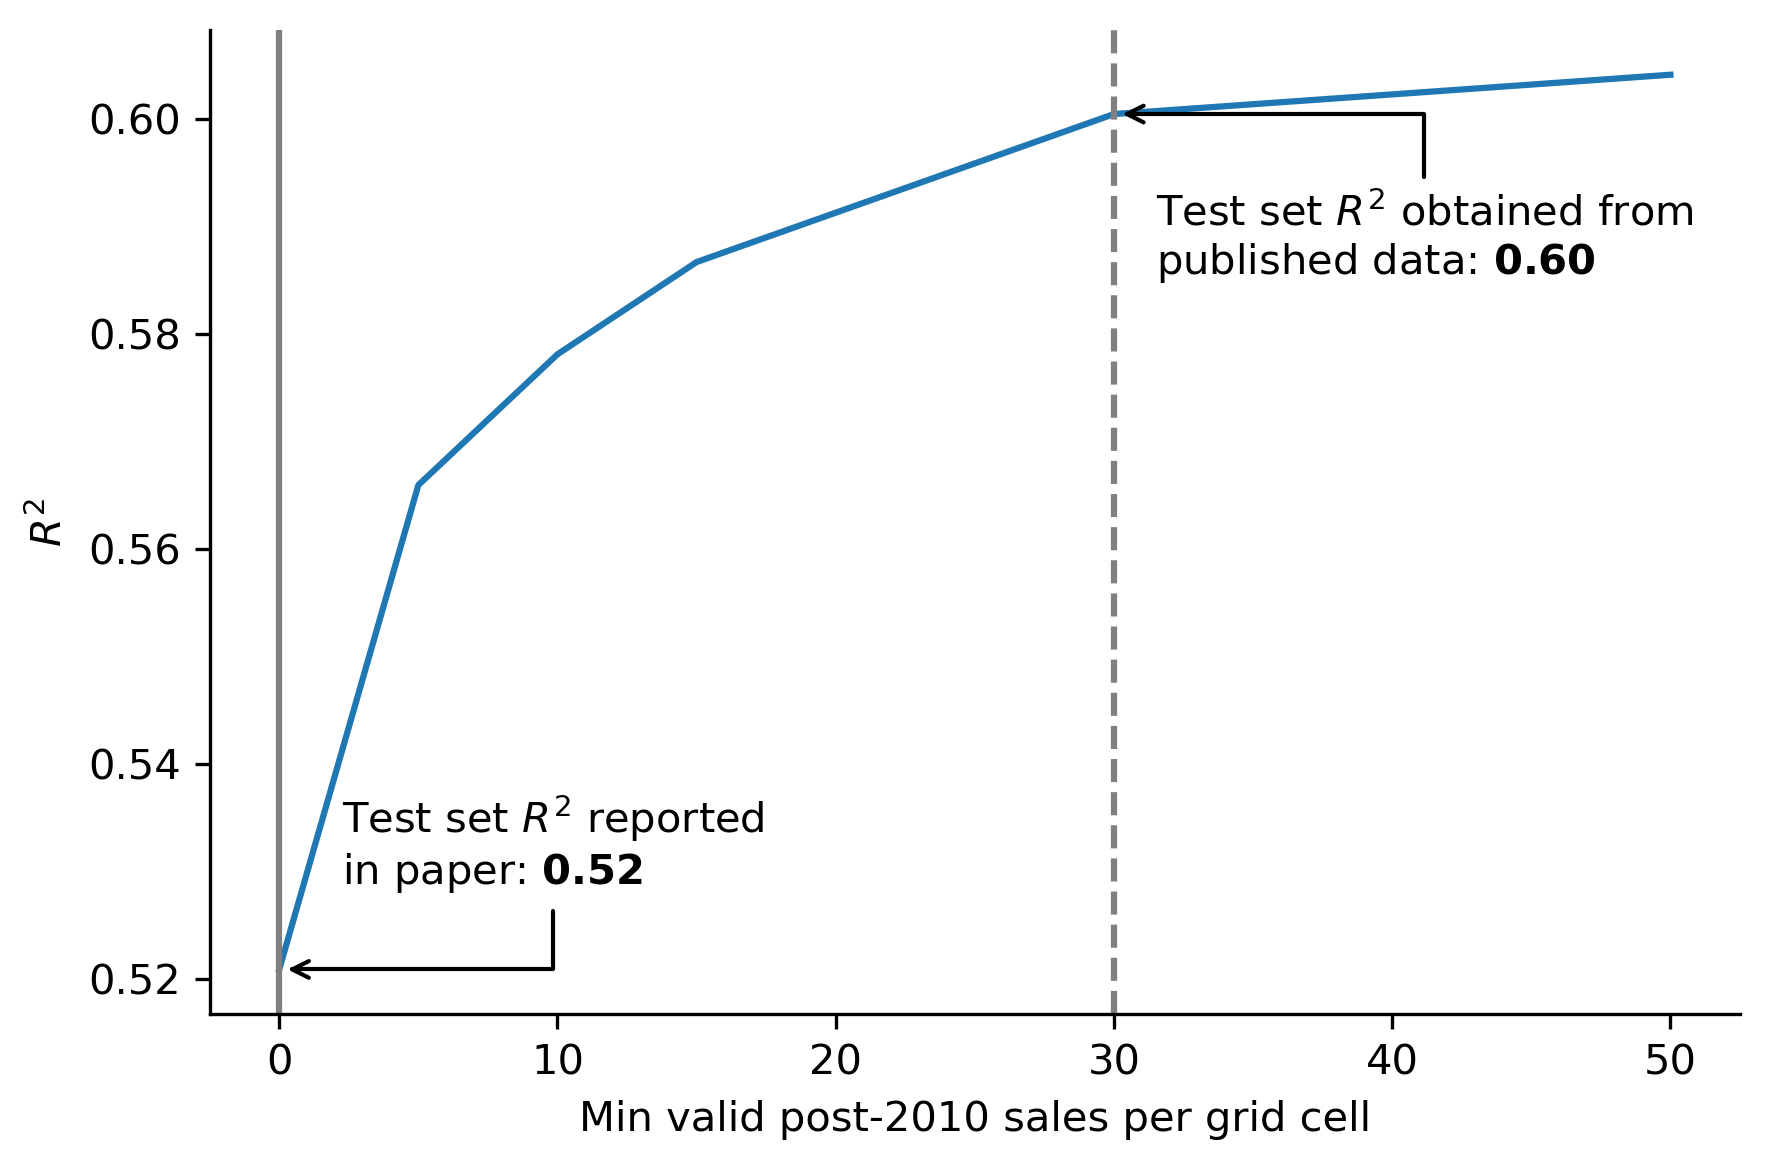

In [115]:
fig, ax = plt.subplots(dpi=300, tight_layout=True)
to_plot = results["Training and testing restricted"]
ax = to_plot.plot(ax=ax)
sns.despine(ax=ax)
ax.set_xlabel("Min valid post-2010 sales per grid cell")
ax.set_ylabel("$R^2$")
ax.axvline(0, linestyle="-", color="grey")
ax.axvline(30, linestyle="--", color="grey")
ax.annotate(
    f"Test set $R^2$ reported\nin paper: $\\mathbf{{{to_plot.loc[0]:.2f}}}$",
    va="center",
    xy=(0, to_plot.loc[0]),
    xycoords="data",
    xytext=(15, 30),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="->", connectionstyle="angle,angleA=90,angleB=0,rad=0", color="k"
    ),
)
ax.annotate(
    f"Test set $R^2$ obtained from\npublished data: $\\mathbf{{{to_plot.loc[30]:.2f}}}$",
    va="center",
    xy=(30, to_plot.loc[30]),
    xycoords="data",
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="->", connectionstyle="angle,angleA=90,angleB=0,rad=0", color="k"
    ),
)
for ext in ["pdf", "jpg"]:
    fig.savefig(Path(cfg.res_dir) / "figures" / "FigS3" / f"FigS3.{ext}", dpi="figure")